# Model Pipeline

Author: Jasmine Qin  
Date: 2020-05-27

In [76]:
# Basics
import pandas as pd
import numpy as np
import seaborn as sns
import time
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectFromModel

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn.metrics import plot_confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, r2_score

# Model Explanation
import eli5
import shap

In [3]:
# Options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Table of Contents
- [1. Load Data](#ld)
- [2. Summary](#s)
- [3. Feature Engineering](#fe)
- [4. Split Data](#sd)
- [5. Preprocessing](#pp)
- [6. Baseline Model](#bm)
- [7. Feature Importance and Selection](#fi)
- [8. Other Models](#om)
- [9. Hyperparameter Tuning](#ht)
- [10. Other Tests](#ot)

## 1. Load Data <a name="ld"></a>

- Run all scripts 01 to 04 to have the combined and cleaned data
- Load `combined_train.csv` and `combined_validate.csv`

In [481]:
train = pd.read_csv('../../data/processed/04_combined_train.csv',
                    low_memory=False)
#validation = pd.read_csv('../../data/processed/04_combined_validate.csv',
#                         low_memory=False).rename(columns={'Geo Local Area': 'LocalArea'})

## 2. Summary <a name="s"></a>

In [482]:
train.head(3)

,business_id,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,BusinessSubType,Unit,UnitType,House,Street,City,Province,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,NextYearStatus,label,BusinessIndustry,Parking meters,Disability parking,Unemployment_rate,Not a visible minority,Total visible minority population
0,1,2018,3100450,18-516072,0.0,!Exotics BySIYTHE Corporation,NaN,Issued,2018-02-14,2018-12-31,Office,Design Company,170,Unit,422,RICHARDS ST,vancouver,BC,CA,V6B 2Z4,Downtown,1.0,189.0,2020-04-01 09:32:19+00:00,"{""type"": ""Point"", ""coordinates"": [-123.1119263...",Pending,0,"Professional, scientific and technical services",3771.0,19.0,4.4,0.563466,0.436534
1,2,2004,804123,04-036444,0.0,.243 Racing Inc,NaN,Issued,2004-04-07,2004-12-31,Wholesale Dealer,NaN,NaN,NaN,1725,POWELL ST,vancouver,BC,CA,V5L 1H6,Grandview-Woodland,NaN,100.0,2019-07-21 13:48:32+00:00,"{""type"": ""Point"", ""coordinates"": [-123.0693914...",Issued,1,Wholesale trade,312.0,7.0,6.8,0.669828,0.330172
2,2,2005,884526,05-112560,0.0,.243 Racing Inc,NaN,Issued,2004-12-23,2005-12-31,Wholesale Dealer,NaN,NaN,NaN,1725,POWELL ST,vancouver,BC,CA,V5L 1H6,Grandview-Woodland,NaN,103.0,2019-07-21 13:48:35+00:00,"{""type"": ""Point"", ""coordinates"": [-123.0693914...",Issued,1,Wholesale trade,312.0,7.0,5.7,0.669828,0.330172


In [483]:
train.groupby(['FOLDERYEAR','LocalArea'])['Not a visible minority'].apply(lambda x: list(x))

FOLDERYEAR  LocalArea          
1997        Arbutus-Ridge          [0.5352564102564102, 0.5352564102564102, 0.535...
            Downtown               [0.6525974025974026, 0.6525974025974026, 0.652...
            Dunbar-Southlands      [0.7355644591091209, 0.7355644591091209, 0.735...
            Fairview               [0.7892921960072595, 0.7892921960072595, 0.789...
            Grandview-Woodland     [0.6490077653149267, 0.6490077653149267, 0.649...
                                                         ...                        
2019        Strathcona             [0.547945205479452, 0.547945205479452, 0.54794...
            Sunset                 [0.17142461197339245, 0.17142461197339245, 0.1...
            Victoria-Fraserview    [0.15792955184388954, 0.15792955184388954, 0.1...
            West End               [0.7135059931506851, 0.7135059931506851, 0.713...
            West Point Grey        [0.6393188854489165, 0.6393188854489165, 0.639...
Name: Not a visible minority, Len

In [484]:
cat_vars = ['FOLDERYEAR', 'BusinessIndustry', 'LocalArea']
label = ['label']

cols_not_used = ['business_id', 'LicenceRSN', 
                 'LicenceNumber', 'LicenceRevisionNumber',
                 'BusinessName', 'BusinessTradeName',
                 'Status', 'IssuedDate', 'ExpiredDate',
                 'BusinessType', 'BusinessSubType',
                 'Unit', 'UnitType', 'House',
                 'Street', 'City', 'Province',
                 'Country', 'PostalCode', 'ExtractDate',
                 'Geom', 'NextYearStatus']

num_vars = [i for i in train.columns if i not in cat_vars and i not in cols_not_used and i not in label]
num_vars

['NumberofEmployees',
 'FeePaid',
 'Parking meters',
 'Disability parking',
 'Unemployment_rate',
 'Not a visible minority',
 'Total visible minority population']

In [485]:
def describe_data(df, num_vars, cat_vars):
    """
    This function prints shape of the given dataframe
    and returns two separate reports for both 
    numeric and categorical variables.
    """
    
    print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns.\n")
    
    num_summary = df[num_vars].describe()
    num_summary.loc['missing'] = [df[s].isnull().sum() for s in num_vars]
    
    cat_summary = {'cat_var':[], 'missing':[], 'unique':[]}
    for c in cat_vars:
        cat_summary['cat_var'].append(c)
        cat_summary['missing'].append(sum(df[c].isnull()))
        cat_summary['unique'].append(len(df[c].unique()))
    
    return num_summary, pd.DataFrame(cat_summary)

In [486]:
num_df, cat_df = describe_data(train, num_vars, cat_vars)
display(num_df, cat_df)

The dataset has 798640 rows and 33 columns.



,NumberofEmployees,FeePaid,Parking meters,Disability parking,Unemployment_rate,Not a visible minority,Total visible minority population
count,224560.000000,743438.000000,709637.000000,754912.000000,798640.000000,692738.000000,692738.000000
mean,13.860352,249.449933,1348.976726,9.923722,6.287580,0.547228,0.452772
std,1144.293346,751.241283,1456.192761,6.646524,1.465802,0.192690,0.192690
min,0.000000,-1624.000000,7.000000,1.000000,4.000000,0.157930,0.139125
25%,1.000000,91.000000,91.000000,4.000000,4.700000,0.386141,0.289020
50%,2.000000,121.000000,898.000000,10.000000,6.600000,0.566919,0.433081
75%,6.000000,166.000000,1624.000000,18.000000,7.400000,0.710980,0.613859
max,300813.000000,84706.000000,3771.000000,19.000000,8.800000,0.860875,0.842070
missing,574080.000000,55202.000000,89003.000000,43728.000000,0.000000,105902.000000,105902.000000


,cat_var,missing,unique
0,FOLDERYEAR,0,23
1,BusinessIndustry,349,17
2,LocalArea,14637,23


In [487]:
train[train.BusinessIndustry.isnull()].BusinessType.unique()

array(["Lounge 'A' *Historic*", 'Auto Wrecker', 'Marine Pub *Historic*',
       'Horse Racing', 'Motel', 'Short-Term Rental'], dtype=object)

In [488]:
train['label'].value_counts()

1    656426
0    142214
Name: label, dtype: int64

## 3. Feauture Engineering <a name="fe"></a>

- Including just cleaning for now, other steps to add in the future
- Will be moved to a separate feature engineering script

In [489]:
def feature_engineering(df):
    df = df[df.LocalArea.notnull()]
    df = df[df.Status == 'Issued']

    df = df[num_vars+cat_vars+label]
    return df.drop(columns=label), df['label']


## 4. Split Data <a name="sd"></a>

- Split data here because Validation set is used directly as Test

In [490]:
X_train_valid, y_train_valid = feature_engineering(train)
#X_test, y_test = feature_engineering(validation)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=2020)

## 5. Preprocessing <a name="pp"></a>

- include polynomial features (interactions, e.g., local area x business type)

In [491]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',
                              fill_value='missing')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

## 6. Baseline Model <a name="bm"></a>

[ROC AUC](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation) source

In [492]:
def evaluate_model(model, X_train=X_train, X_test=X_valid, y_train=y_train, y_test=y_valid, verbose=True):
    """
    This function prints train and test accuracies,
    classification report, and confusion matrix.
    """
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    if verbose:
        print("Train Accuracy:", train_acc)
        print("Validation Accuracy", test_acc, "\n")

        print(classification_report(y_test, model.predict(X_test)))
        print(plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=[0, 1],
                                     cmap=plt.cm.Blues,
                                     values_format='d'))
    else:
        report = {}
        f1 = f1_score(y_test, model.predict(X_test))
        recall = recall_score(y_test, model.predict(X_test))
        precision = precision_score(y_test, model.predict(X_test))
        report['renewed'] = [f1, recall, precision]
        
        f1 = f1_score(y_test, model.predict(X_test), pos_label=0)
        recall = recall_score(y_test, model.predict(X_test), pos_label=0)
        precision = precision_score(y_test, model.predict(X_test), pos_label=0)
        report['not_renewed'] = [f1, recall, precision]
        
        report['accuracy'] = [train_acc, test_acc]
        
        return report

In [493]:
def roc_curve_auc(model, X_train=X_train, X_test=X_valid, y_train=y_train, y_test=y_valid):
    """
    This function plots ROC curve and prints AUC score.
    """
    # assume fit model first
    #mode.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        
    fig = plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr)
    plt.plot((0,1),(0,1),'--k')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.annotate(f'AUC score = {auc: .4f}', (0.0, 0.9))

The max_iter was reached which means the coef_ did not converge


Train Accuracy: 0.5037989880799245
Validation Accuracy 0.5059445812723393 

              precision    recall  f1-score   support

           0       0.17      0.68      0.28     20090
           1       0.90      0.48      0.63    125673

    accuracy                           0.51    145763
   macro avg       0.54      0.58      0.45    145763
weighted avg       0.80      0.51      0.58    145763



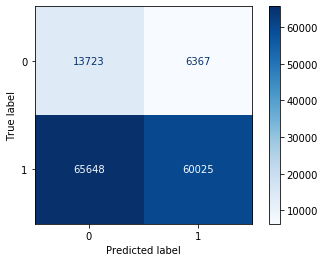

In [494]:
lr = LogisticRegression(solver='saga', class_weight='balanced')

lr_pip = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', lr)])

evaluate_model(lr_pip)

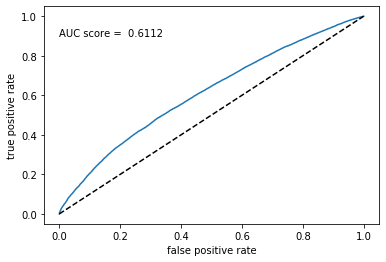

In [495]:
roc_curve_auc(lr_pip)

## 7. Feature Importance and Selection <a name="fi"></a>

- weights
- RFE
- L1, L2
- PCA

In [496]:
def explain_model(pip, df, verbose=True):
    pp1_features = num_vars + \
        list(pip['preprocessor'].transformers_[
             1][1]['onehot'].get_feature_names())
    
    return eli5.show_weights(pip['classifier'],
                             feature_names=pp1_features,
                             top=30)


In [497]:
explain_model(lr_pip, X_train)

Weight?,Feature
+0.666,x1_Real estate and rental and leasing
+0.492,x1_Health care and social assistance
+0.306,x1_Finance and insurance
+0.181,x2_Strathcona
+0.175,x0_2010
+0.156,x0_2009
+0.151,FeePaid
+0.148,x0_2012
+0.135,NumberofEmployees
+0.103,x1_Manufacturing


## 8. Other Models <a name="om"></a>

Train Accuracy: 0.5767241231455278
Validation Accuracy 0.5757085131343345 

              precision    recall  f1-score   support

           0       0.19      0.64      0.30     20090
           1       0.91      0.56      0.70    125673

    accuracy                           0.58    145763
   macro avg       0.55      0.60      0.50    145763
weighted avg       0.81      0.58      0.64    145763



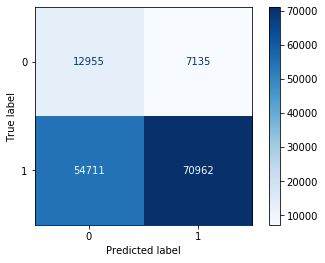

In [498]:
lgbm = LGBMClassifier(class_weight='balanced')

lgbm_pip = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', lgbm)])

evaluate_model(lgbm_pip)

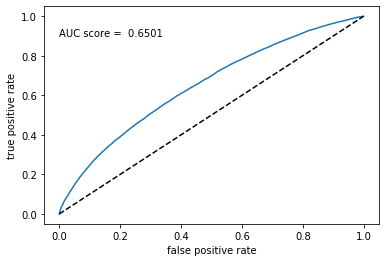

In [499]:
roc_curve_auc(lgbm_pip)

In [500]:
explain_model(lgbm_pip, X_train)

Weight,Feature
0.2707,x1_Real estate and rental and leasing
0.2544,FeePaid
0.1241,NumberofEmployees
0.0583,Unemployment_rate
0.0572,x1_Health care and social assistance
0.0387,Parking meters
0.0291,Not a visible minority
0.0183,x1_Finance and insurance
0.0140,x1_Information and cultural industries
0.0131,"x1_Professional, scientific and technical services"


## 9. Hyperparameter Tuning <a name="ht"></a>

- regularization strength
- tree max depth
- sampling strategy for SMOTE
- missing value imputing strategy
- degree of polynomial terms

In [47]:
lrhp = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LGBMClassifier(class_weight='balanced'))])

param_grid = {
    'classifier__reg_lambda': [0.1, 1],
}

#gs = GridSearchCV(lrhp, param_grid, cv=5, scoring='f1')
#gs.fit(X_train, y_train);

## 10. Other Tests <a name="ot"></a>

- SMOTE

Train Accuracy: 0.7795397762536005
Validation Accuracy 0.7763190350018698
              precision    recall  f1-score   support

           0       0.24      0.26      0.25     17926
           1       0.87      0.86      0.87    107753

    accuracy                           0.78    125679
   macro avg       0.56      0.56      0.56    125679
weighted avg       0.78      0.78      0.78    125679



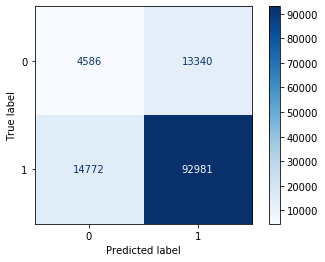

In [51]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
smote_pip = Pipeline(steps=[('preprocessor', preprocessor),
                            ('smote', SMOTE(sampling_strategy=0.85)),
                            ('classifier', lgbm)])

param_grid = {
    'smote__sampling_strategy': [0.1, 0.5, 0.8, 1.0],
}

#gs = GridSearchCV(smote_pip, param_grid, cv=5, scoring='f1')
#gs.fit(X_train_valid, y_train_valid)
evaluate_model(smote_pip)

# Compare results from adding different census information

In [84]:
# 1. marital_status

marital_status_lr = evaluate_model(lr_pip, verbose=False)
marital_status_lgbm = evaluate_model(lgbm_pip, verbose=False)

marital_status_explain_lr = explain_model(lr_pip, X_train)
marital_status_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [109]:
# 2. household_size

household_size_lr = evaluate_model(lr_pip, verbose=False)
household_size_lgbm = evaluate_model(lgbm_pip, verbose=False)

household_size_explain_lr = explain_model(lr_pip, X_train)
household_size_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [135]:
# 3. population_age

population_age_lr = evaluate_model(lr_pip, verbose=False)
population_age_lgbm = evaluate_model(lgbm_pip, verbose=False)

population_age_explain_lr = explain_model(lr_pip, X_train)
population_age_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [158]:
# 4. industry

industry_lr = evaluate_model(lr_pip, verbose=False)
industry_lgbm = evaluate_model(lgbm_pip, verbose=False)

industry_explain_lr = explain_model(lr_pip, X_train)
industry_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [182]:
# 5. transport_mode

transport_mode_lr = evaluate_model(lr_pip, verbose=False)
transport_mode_lgbm = evaluate_model(lgbm_pip, verbose=False)

transport_mode_explain_lr = explain_model(lr_pip, X_train)
transport_mode_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [213]:
# 6. language

language_lr = evaluate_model(lr_pip, verbose=False)
language_lgbm = evaluate_model(lgbm_pip, verbose=False)

language_explain_lr = explain_model(lr_pip, X_train)
language_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [236]:
# 7. gender

gender_lr = evaluate_model(lr_pip, verbose=False)
gender_lgbm = evaluate_model(lgbm_pip, verbose=False)

gender_explain_lr = explain_model(lr_pip, X_train)
gender_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [260]:
# 8. immigration_birthplace

immigration_birthplace_lr = evaluate_model(lr_pip, verbose=False)
immigration_birthplace_lgbm = evaluate_model(lgbm_pip, verbose=False)

immigration_birthplace_explain_lr = explain_model(lr_pip, X_train)
immigration_birthplace_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [289]:
# 9. occupation

occupation_lr = evaluate_model(lr_pip, verbose=False)
occupation_lgbm = evaluate_model(lgbm_pip, verbose=False)

occupation_explain_lr = explain_model(lr_pip, X_train)
occupation_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [311]:
# 10. labour_force

labour_force_lr = evaluate_model(lr_pip, verbose=False)
labour_force_lgbm = evaluate_model(lgbm_pip, verbose=False)

labour_force_explain_lr = explain_model(lr_pip, X_train)
labour_force_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [335]:
# 11. time_worked

time_worked_lr = evaluate_model(lr_pip, verbose=False)
time_worked_lgbm = evaluate_model(lgbm_pip, verbose=False)

time_worked_explain_lr = explain_model(lr_pip, X_train)
time_worked_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [357]:
# 12. education

education_lr = evaluate_model(lr_pip, verbose=False)
education_lgbm = evaluate_model(lgbm_pip, verbose=False)

education_explain_lr = explain_model(lr_pip, X_train)
education_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [381]:
# 13. generation

generation_lr = evaluate_model(lr_pip, verbose=False)
generation_lgbm = evaluate_model(lgbm_pip, verbose=False)

generation_explain_lr = explain_model(lr_pip, X_train)
generation_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [403]:
# 14. workplace

workplace_lr = evaluate_model(lr_pip, verbose=False)
workplace_lgbm = evaluate_model(lgbm_pip, verbose=False)

workplace_explain_lr = explain_model(lr_pip, X_train)
workplace_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [425]:
# 15. lone_parent

lone_parent_lr = evaluate_model(lr_pip, verbose=False)
lone_parent_lgbm = evaluate_model(lgbm_pip, verbose=False)

lone_parent_explain_lr = explain_model(lr_pip, X_train)
lone_parent_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [448]:
# 16. dwelling_type

dwelling_type_lr = evaluate_model(lr_pip, verbose=False)
dwelling_type_lgbm = evaluate_model(lgbm_pip, verbose=False)

dwelling_type_explain_lr = explain_model(lr_pip, X_train)
dwelling_type_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [479]:
# 17. shelter_tenure

shelter_lr = evaluate_model(lr_pip, verbose=False)
shelter_lgbm = evaluate_model(lgbm_pip, verbose=False)

shelter_explain_lr = explain_model(lr_pip, X_train)
shelter_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [501]:
# 18. visible_minority

visible_minority_lr = evaluate_model(lr_pip, verbose=False)
visible_minority_lgbm = evaluate_model(lgbm_pip, verbose=False)

visible_minority_explain_lr = explain_model(lr_pip, X_train)
visible_minority_explain_lgbm = explain_model(lgbm_pip, X_train)

The max_iter was reached which means the coef_ did not converge


In [568]:
census_results = {'marital_status_lr': marital_status_lr,
                  'marital_status_lgbm': marital_status_lgbm,
                  'household_size_lr': household_size_lr,
                  'household_size_lgbm': household_size_lgbm,
                  'population_age_lr': population_age_lr,
                  'population_age_lgbm': population_age_lgbm,
                  'industry_lr': industry_lr,
                  'industry_lgbm': industry_lgbm,
                  'transport_mode_lr': transport_mode_lr,
                  'transport_mode_lgbm': transport_mode_lgbm,
                  'language_lr': language_lr,
                  'language_lgbm': language_lgbm,
                  'gender_lr': gender_lr,
                  'gender_lgbm': gender_lgbm,
                  'immigration_birthplace_lr': immigration_birthplace_lr,
                  'immigration_birthplace_lgbm': immigration_birthplace_lgbm,
                  'occupation_lr': occupation_lr,
                  'occupation_lgbm': occupation_lgbm,
                  'labour_force_lr': labour_force_lr,
                  'labour_force_lgbm': labour_force_lgbm,
                  'time_worked_lr': time_worked_lr,
                  'time_worked_lgbm': time_worked_lgbm,
                  'education_lr': education_lr,
                  'education_lgbm': education_lgbm,
                  'generation_lr': generation_lr,
                  'generation_lgbm': generation_lr,
                  'workplace_lr': workplace_lr,
                  'workplace_lgbm': workplace_lgbm,
                  'lone_parent_lr': lone_parent_lr,
                  'lone_parent_lgbm': lone_parent_lgbm,
                  'dwelling_type_lr': dwelling_type_lr,
                  'dwelling_type_lgbm': dwelling_type_lgbm,
                  'shelter_lr': shelter_lr,
                  'shelter_lgbm': shelter_lgbm,
                  'visible_minority_lr': visible_minority_lr,
                  'visible_minority_lgbm': visible_minority_lgbm}

f1_dict = {'name': [],
           'renewed': [],
           'not_renewed': []}

recall_dict = {'name': [],
               'renewed': [],
               'not_renewed': []}

precision_dict = {'name': [],
                  'renewed': [],
                  'not_renewed': []}

accuracy_dict = {'name': [],
                 'train_acc': [],
                 'valid_acc': []}

for key, value in census_results.items():
    f1_dict['name'].append(key)
    f1_dict['renewed'].append(value['renewed'][0])
    f1_dict['not_renewed'].append(value['not_renewed'][0])

    recall_dict['name'].append(key)
    recall_dict['renewed'].append(value['renewed'][1])
    recall_dict['not_renewed'].append(value['not_renewed'][1])

    precision_dict['name'].append(key)
    precision_dict['renewed'].append(value['renewed'][2])
    precision_dict['not_renewed'].append(value['not_renewed'][2])

    accuracy_dict['name'].append(key)
    accuracy_dict['train_acc'].append(value['accuracy'][0])
    accuracy_dict['valid_acc'].append(value['accuracy'][1])
    
f1_df = pd.DataFrame(f1_dict).sort_values('renewed')
recall_df = pd.DataFrame(recall_dict).sort_values('renewed')
precision_df = pd.DataFrame(precision_dict).sort_values('renewed')
accuracy_df = pd.DataFrame(accuracy_dict).sort_values('valid_acc')

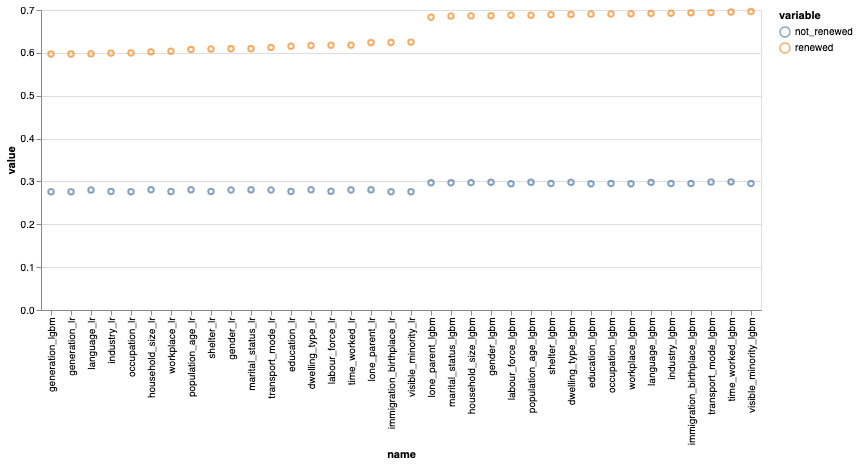

In [579]:
import altair as alt

alt.Chart(f1_df.melt(id_vars='name')).mark_point().encode(
    x=alt.X('name:N', sort=list(f1_df.name)),
    y=alt.Y('value:Q'),
    color='variable'
    )

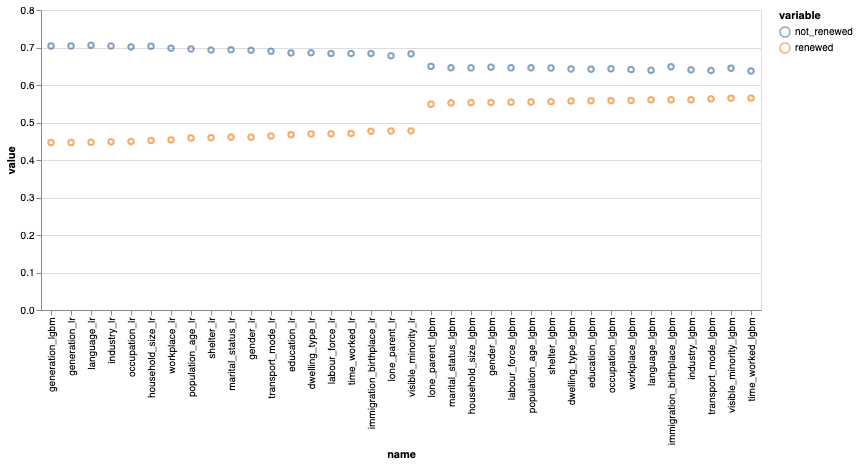

In [580]:
alt.Chart(recall_df.melt(id_vars='name')).mark_point().encode(
    x=alt.X('name:N', sort=list(recall_df.name)),
    y=alt.Y('value:Q'),
    color='variable'
    )

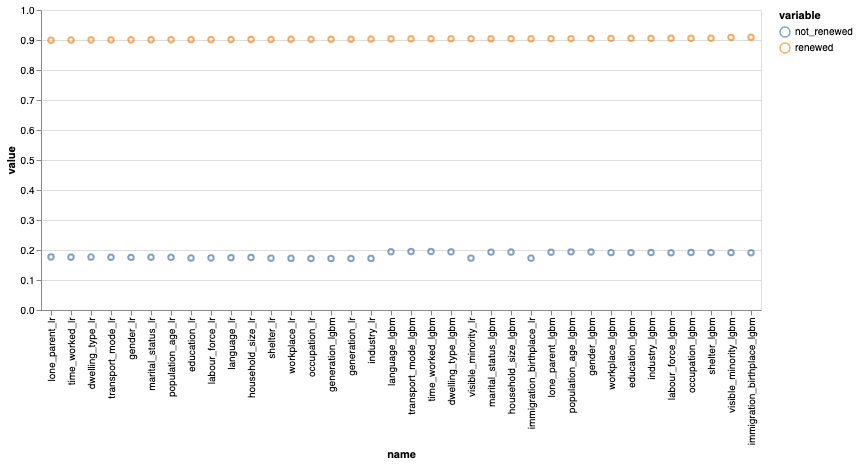

In [581]:
alt.Chart(precision_df.melt(id_vars='name')).mark_point().encode(
    x=alt.X('name:N', sort=list(precision_df.name)),
    y=alt.Y('value:Q'),
    color='variable'
    )

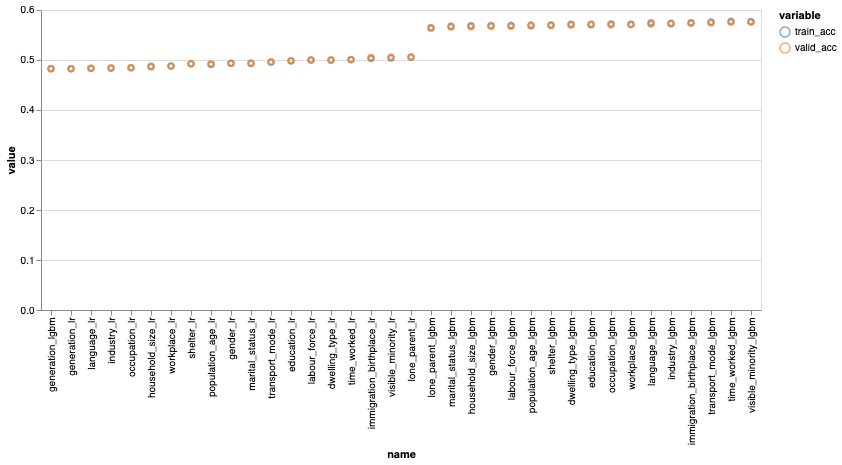

In [582]:
alt.Chart(accuracy_df.melt(id_vars='name')).mark_point().encode(
    x=alt.X('name:N', sort=list(accuracy_df.name)),
    y=alt.Y('value:Q'),
    color='variable'
    )